<a href="https://colab.research.google.com/github/manikanta318/Urban-Sprawl-Monitoring-Local-GIS-Image-Processing-/blob/main/Urban_Sprawl_Monitoring_Local_GIS_Image_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# === Install required geospatial libraries ===
!pip install rasterio geopandas shapely fiona pyproj matplotlib numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 103.3 MB/s eta 0:00:00


🖼️ Loaded standard image: /content/landsat_2010.webp
⚠️ Non-GIS image — simulating NIR=Red & SWIR=Blue
🖼️ Loaded standard image: /content/landsat_2020.webp
⚠️ Non-GIS image — simulating NIR=Red & SWIR=Blue


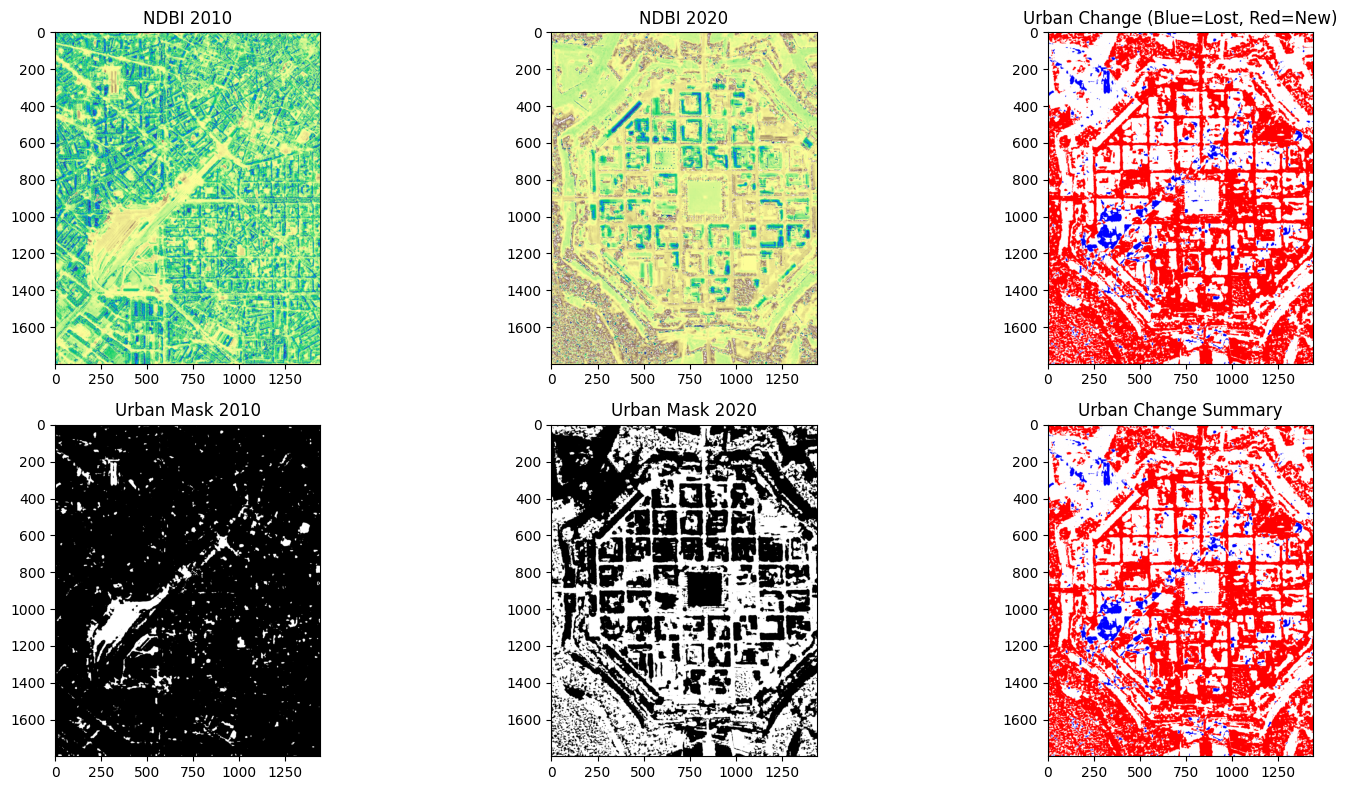

✅ Urban sprawl analysis complete.


In [4]:
# =========================================================
# URBAN SPRAWL MONITORING (Flexible for .tif / .jpg / .webp)
# =========================================================

!pip install rasterio geopandas shapely fiona pyproj matplotlib numpy opencv-python --quiet

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
import os

warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

# === Helper: NDBI Calculation ===
def calculate_ndbi(nir, swir):
    """Normalized Difference Built-up Index"""
    ndbi = (swir - nir) / (swir + nir + 1e-10)
    ndbi[np.isinf(ndbi)] = np.nan
    return ndbi

# === Helper: Smart image loader (handles .tif and .webp) ===
def load_image_auto(path):
    ext = os.path.splitext(path)[1].lower()
    if ext in ['.tif', '.tiff']:
        src = rasterio.open(path)
        bands = src.count
        print(f"🛰️ Loaded GeoTIFF with {bands} bands")

        if bands >= 6:
            nir = src.read(5).astype('float32')
            swir = src.read(6).astype('float32')
            print("✅ Using NIR=Band5 & SWIR=Band6")
        elif bands >= 3:
            red = src.read(1).astype('float32')
            green = src.read(2).astype('float32')
            blue = src.read(3).astype('float32')
            nir, swir = red, blue
            print("⚠️ Only RGB found — simulating NIR=Red, SWIR=Blue")
        else:
            print("❌ Too few bands — generating random test data")
            nir = np.random.rand(512, 512)
            swir = np.random.rand(512, 512)
    else:
        print(f"🖼️ Loaded standard image: {path}")
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(f"Image not found: {path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('float32') / 255.0
        red, green, blue = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        nir, swir = red, blue
        print("⚠️ Non-GIS image — simulating NIR=Red & SWIR=Blue")

    return nir, swir

# === File paths ===
image_2010_path = "/content/landsat_2010.webp"
image_2020_path = "/content/landsat_2020.webp"

# === Load images ===
nir_2010, swir_2010 = load_image_auto(image_2010_path)
nir_2020, swir_2020 = load_image_auto(image_2020_path)

# === Compute NDBI ===
ndbi_2010 = calculate_ndbi(nir_2010, swir_2010)
ndbi_2020 = calculate_ndbi(nir_2020, swir_2020)

# === Classify built-up ===
urban_2010 = np.where(ndbi_2010 > 0, 1, 0)
urban_2020 = np.where(ndbi_2020 > 0, 1, 0)

# === Detect change ===
change_map = urban_2020 - urban_2010  # 1=new urban, -1=lost urban

# === Visualization ===
plt.figure(figsize=(16, 8))
plt.subplot(2, 3, 1)
plt.imshow(ndbi_2010, cmap='terrain')
plt.title("NDBI 2010")

plt.subplot(2, 3, 2)
plt.imshow(ndbi_2020, cmap='terrain')
plt.title("NDBI 2020")

plt.subplot(2, 3, 3)
plt.imshow(change_map, cmap='bwr', vmin=-1, vmax=1)
plt.title("Urban Change (Blue=Lost, Red=New)")

plt.subplot(2, 3, 4)
plt.imshow(urban_2010, cmap='gray')
plt.title("Urban Mask 2010")

plt.subplot(2, 3, 5)
plt.imshow(urban_2020, cmap='gray')
plt.title("Urban Mask 2020")

plt.subplot(2, 3, 6)
plt.imshow(change_map, cmap='bwr', vmin=-1, vmax=1)
plt.title("Urban Change Summary")

plt.tight_layout()
plt.show()

print("✅ Urban sprawl analysis complete.")
